In [1]:
!ls

data-preprocessing.ipynb  Testing  Training


In [2]:
!ls Testing

glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor


In [3]:
%matplotlib inline

In [36]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm

In [5]:
def find_image_fnames(basedir):
    for root, dirs, fnames in os.walk(basedir):
        for fname in fnames:    
            yield os.path.join(root, fname)
            
def find_images_with_labels(basedir):
    images = []
    labels = []
    
    for tumor_type in os.listdir(basedir):
        for fname in find_image_fnames(os.path.join(basedir, tumor_type)):
            images.append(fname)
            labels.append(tumor_type)
            
    return images, labels

In [6]:
testing_fnames, testing_labels = find_images_with_labels("./Testing")
training_fnames, training_labels = find_images_with_labels("./Training")

In [7]:
n_testing = len(testing_fnames)
n_training = len(training_fnames)

print(f"# testing: {n_testing}")
print(f"# training: {n_training}")

# testing: 394
# training: 2870


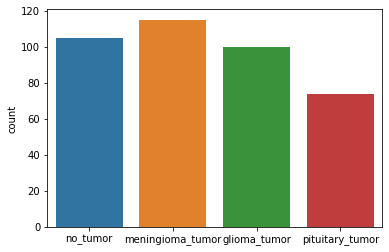

In [8]:
sns.countplot(x=testing_labels);

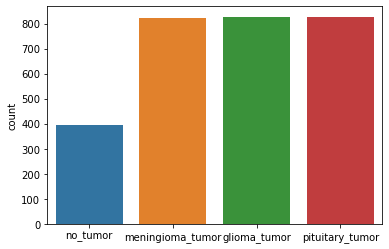

In [9]:
sns.countplot(x=training_labels);

In [10]:
def read_image(fname):
    return imread(fname)

In [11]:
sizes = [read_image(fname).shape[0] for fname in testing_fnames]

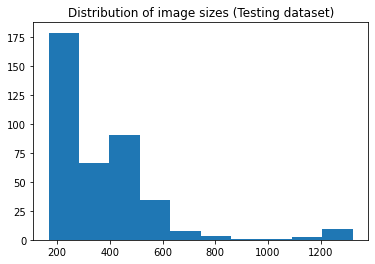

In [12]:
plt.hist(sizes)
plt.title("Distribution of image sizes (Testing dataset)")

pass

In [13]:
np.mean(sizes)

385.0253807106599

In [14]:
np.median(sizes)

321.0

In [15]:
def convert_image(image, target_size=(300, 300)):
    image = resize(image, target_size, anti_aliasing=True)
    image = rgb2gray(image)
    return (255*image).astype(np.uint8)

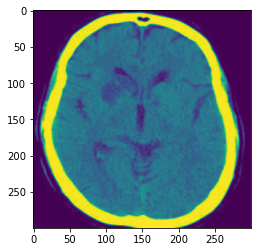

In [16]:
resized_testing = convert_image(read_image(testing_fnames[0]))

plt.imshow(resized_testing)

In [17]:
resized_testing.dtype, resized_testing.shape

(dtype('uint8'), (300, 300))

In [18]:
def process_all(fnames, target_size=(300, 300)):
    resized = np.empty((len(fnames),) + target_size, dtype=np.uint8)
    for n, fname in enumerate(tqdm(fnames)):
        image = read_image(fname)
        resized[n] = convert_image(image, target_size=target_size)
    return resized

In [20]:
testing = process_all(testing_fnames)

print(testing.shape)

100%|██████████| 394/394 [00:14<00:00, 27.41it/s]

(394, 300, 300)


In [52]:
training = process_all(training_fnames)

print(training.shape)

100%|██████████| 2870/2870 [01:53<00:00, 25.21it/s]

(2870, 300, 300)


In [53]:
encoder = LabelEncoder()
encoder.fit(training_labels + testing_labels)
encoder.classes_

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [54]:
def one_hot_encode(labels):
    return to_categorical(encoder.transform(labels))

In [62]:
y_train = one_hot_encode(training_labels)
y_test = one_hot_encode(testing_labels)

In [63]:
x_train, x_validate, y_train, y_validate = train_test_split(
    training, y_train, test_size=0.2, shuffle=True, random_state=1234
)
x_test = testing

In [64]:
def one_hot_decode(codes):
    indices = np.where(codes)[1]
    return encoder.classes_[indices]

<AxesSubplot:ylabel='count'>

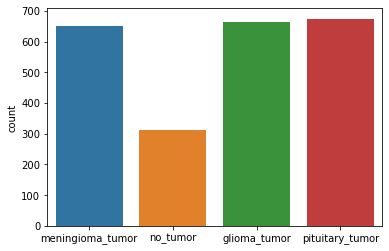

In [65]:
sns.countplot(x=one_hot_decode(y_train))

<AxesSubplot:ylabel='count'>

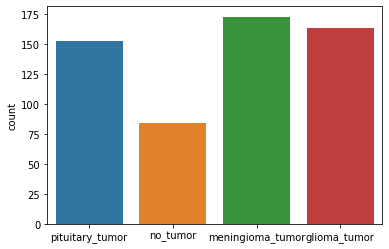

In [66]:
sns.countplot(x=one_hot_decode(y_validation))

In [67]:
np.savez(
    "train-test-validate.npz",
    x_train=x_train,
    y_train=y_train,
    x_validate=x_validate,
    y_validate=y_validate,
    x_test=x_test,
    y_test=y_test,
    classes=encoder.classes_
)